# Neural networks extended project - Oliver Gatland

In [3]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, TargetEncoder, RobustScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import metrics, regularizers, constraints
from keras import initializers

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import shap

In [4]:
# Loading data
df_train = pd.read_csv("C:/Users/gatla/OneDrive/BSE/CL_DL/project_2/dl24-length-of-stay-prediction-nn-ensembles/mimic_train.csv")
df_test = pd.read_csv("C:/Users/gatla/OneDrive/BSE/CL_DL/project_2/dl24-length-of-stay-prediction-nn-ensembles/mimic_test_los.csv")

## Preprocessing

Note I use the exact same pre-processing as that from the KNN and SVM project.

In [5]:
df_train.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [6]:
df_test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [7]:
# Remove columns in the train data not present in the test (but keep length of saty)
common_columns = df_train.columns.intersection(df_test.columns)
df_train = df_train[list(common_columns) + ['LOS']]

We just use the mean of the numeric variables. I experimented with adding the min and max but it did not improve the out of sample prediction.

In [8]:
# Keep only mean numerical variables
df_train.drop(columns=[col for col in df_train.columns if col.endswith('Min') or col.endswith('Max')], inplace=True)
df_test.drop(columns=[col for col in df_test.columns if col.endswith('Min') or col.endswith('Max')], inplace=True)

### Missing values

In [9]:
# Check missing values in train
df_train.isna().sum()

subject_id           0
hadm_id              0
icustay_id           0
HeartRate_Mean    2187
SysBP_Mean        2208
DiasBP_Mean       2209
MeanBP_Mean       2186
RespRate_Mean     2189
TempC_Mean        2497
SpO2_Mean         2203
Glucose_Mean       253
GENDER               0
DOB                  0
ADMITTIME            0
Diff                 0
ADMISSION_TYPE       0
INSURANCE            0
RELIGION             0
MARITAL_STATUS     722
ETHNICITY            0
DIAGNOSIS            0
ICD9_diagnosis       0
FIRST_CAREUNIT       0
LOS                  0
dtype: int64

In [10]:
# Check missing values in test
df_test.isna().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Mean    545
SysBP_Mean        551
DiasBP_Mean       552
MeanBP_Mean       547
RespRate_Mean     546
TempC_Mean        638
SpO2_Mean         551
Glucose_Mean       58
GENDER              0
DOB                 0
ADMITTIME           0
Diff                0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS    180
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
dtype: int64

Only cols with missing values are the numericals and marital status. Numericals will be imputed with KNN, marital status is investigated further below.

### Categorical variables

Investigating the following columns that are likely to be appropriate for one hot encoding: 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS'. If possible, it is best to one hot encode categorical variables as it allows us to capture the variation for each category within the model. The main downside is it can often increase the dimensionality of the data, as we add a new column for each possible value of the variable. If there is a high number of unique values for a variable, using one hot encoding would significantly increase the dimensionality of the data. This is computationally expensive, but can also impact the predictive performance of a model, known as the 'curse of dimensionality'.

Below I check the number of values for each of these variables, and if there is a low number of unique values, and if each value has a sufficient number of observations, I will one hot encode them. 

In [11]:
print(df_train['GENDER'].unique())
print(df_train['ADMISSION_TYPE'].unique())
print(df_train['INSURANCE'].unique())
print(df_train['MARITAL_STATUS'].unique())

['F' 'M']
['EMERGENCY' 'ELECTIVE' 'URGENT']
['Medicare' 'Private' 'Medicaid' 'Self Pay' 'Government']
['SINGLE' 'MARRIED' 'SEPARATED' 'WIDOWED' 'DIVORCED' nan
 'UNKNOWN (DEFAULT)' 'LIFE PARTNER']


In [12]:
print(df_train['GENDER'].value_counts())
print(df_train['ADMISSION_TYPE'].value_counts())
print(df_train['INSURANCE'].value_counts())
print(df_train['MARITAL_STATUS'].value_counts())

GENDER
M    11759
F     9126
Name: count, dtype: int64
ADMISSION_TYPE
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: count, dtype: int64
INSURANCE
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: count, dtype: int64
MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: count, dtype: int64


All have sufficient values for one hot encoding aside from 'LIFE PARTNER' for marital status. I will combine this with the UNKNOWN column to form a 'other' category.

In [13]:
# Creating 'other' category in marital status
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].replace(['UNKNOWN (DEFAULT)', 'LIFE PARTNER'], 'OTHER')
df_test['MARITAL_STATUS'] = df_test['MARITAL_STATUS'].replace(['UNKNOWN (DEFAULT)', 'LIFE PARTNER'], 'OTHER')

As mentioned previously, marital status was the only non-numeric variable with missing values. I look if the patients with missing values tend to have a different length of stay.

In [14]:
df_train['MARITAL_STATUS'].fillna('MISSING', inplace=True)
mean_values = df_train .groupby('MARITAL_STATUS')['LOS'].mean()
print(mean_values)

MARITAL_STATUS
DIVORCED     3.732979
MARRIED      3.754372
MISSING      3.946407
OTHER        4.324216
SEPARATED    3.843752
SINGLE       3.652800
WIDOWED      3.502518
Name: LOS, dtype: float64


It appears those with NAs have a slightly longer LOS on average, I will fill all missing values with the value of OTHER.

In [15]:
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].replace('MISSING', 'OTHER')
df_test['MARITAL_STATUS'].fillna('OTHER', inplace=True)

Now I look into the religion and ethnicity variables, as these may have too many unique values to one hot encode.

In [16]:
# Checking the number of unique religions
df_train['RELIGION'].value_counts()

RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: count, dtype: int64

There are enough values for most religions to justify one hot encoding, but I add all religions with less than 100 followers to the 'other' category to reduce dimensions.

In [17]:
# Grouping toegther smaller religions
df_train['RELIGION'] = df_train['RELIGION'].replace(['MUSLIM', 'UNITARIAN-UNIVERSALIST', "JEHOVAH'S WITNESS", 'ROMANIAN EAST. ORTH', 'HINDU', '7TH DAY ADVENTIST', 'HEBREW'], 'OTHER')
df_test['RELIGION'] = df_test['RELIGION'].replace(['MUSLIM', 'UNITARIAN-UNIVERSALIST', "JEHOVAH'S WITNESS", 'ROMANIAN EAST. ORTH', 'HINDU', '7TH DAY ADVENTIST', 'HEBREW'], 'OTHER')

In [18]:
# Checking the number of unique ethnicities
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58


There are too many different values for ethnicity to one hot encode. I group these into similar ethnicities to reduce the dimensionality.

In [19]:
# Grouping major ethnic groups
ethnic_groups = ['WHITE', 'BLACK', 'HISPANIC', 'ASIAN']

for group in ethnic_groups:
    df_train.loc[df_train['ETHNICITY'].str.contains(group), 'ETHNICITY'] = group
    df_test.loc[df_test['ETHNICITY'].str.contains(group), 'ETHNICITY'] = group


# Combining the two 'unknown' variables
df_train['ETHNICITY'] = df_train['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED'], 'UNKNOWN')
df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED'], 'UNKNOWN')

# Adding anything with less than 100 obvs into the 'other' category
ethnicity_counts = df_train['ETHNICITY'].value_counts()
ethnicities_to_replace = ethnicity_counts[ethnicity_counts < 100].index.tolist()
df_train.loc[df_train['ETHNICITY'].isin(ethnicities_to_replace), 'ETHNICITY'] = 'OTHER'
df_test.loc[df_test['ETHNICITY'].isin(ethnicities_to_replace), 'ETHNICITY'] = 'OTHER'

In [20]:
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                         15330
BLACK                          2201
UNKNOWN                        1145
HISPANIC                        852
OTHER                           637
ASIAN                           545
PATIENT DECLINED TO ANSWER      175
Name: count, dtype: int64

Now we have grouped the ethnicities so they can be one hot encoded. All categorical variables are one hot encoded later in the notebook.

### ICD9 variable

The ICD9 column only contains the main diagnosis, we can load the extra data which has further diagnosis' for the patient.

In [21]:
# Load meta data
data_meta = pd.read_csv("C:/Users/gatla/OneDrive/BSE/CL_DL/project_2/dl24-length-of-stay-prediction-nn-ensembles/extra_data/MIMIC_diagnoses.csv")  
data_meta = data_meta.rename(columns= {'ICD9_CODE': 'ICD9_diagnosis', 'SUBJECT_ID': 'subject_id', 'HADM_ID': 'hadm_id'})

data_meta

,subject_id,hadm_id,SEQ_NUM,ICD9_diagnosis
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859
...,...,...,...,...
651042,65535,178280,5.0,5119
651043,65535,178280,6.0,5990
651044,65535,178280,7.0,0414
651045,65535,178280,8.0,25000


Where SEQ = 1 we have the same information that is in the original dataset, so these are dropped. I also only keep the top 10 diagnosis as some patients have a large number of ICD9 numbers.

In [22]:
data_meta = data_meta[data_meta['SEQ_NUM'].between(2, 10)]

Now we merge the secondary ICD9 numbers into the main dataset.

In [23]:
data_meta = data_meta.pivot(index=['subject_id', 'hadm_id'], columns= 'SEQ_NUM', values='ICD9_diagnosis')
data_meta = data_meta.reset_index()

# Rename columns 
data_meta.columns = ['subject_id'] + ['hadm_id'] + [f'ICD9_{col}' for col in data_meta.columns[2:]]

# Merge in columns
df_train = df_train.merge(data_meta, on=['subject_id', 'hadm_id'], how='left')
df_test = df_test.merge(data_meta, on=['subject_id', 'hadm_id'], how='left')

# Rename original ICD9 col
df_train.rename(columns={'ICD9_diagnosis': 'ICD9_1.0'}, inplace=True)
df_test.rename(columns={'ICD9_diagnosis': 'ICD9_1.0'}, inplace=True)

There are too many ICD9 cols and values to use one hot encoding. One other option for categorical variables of this nature is to use target encoding. This condenses the information within categorical variables into a single feature that represents the mean of some target value. In this case, I use the death flag as the target variable, so each ICD9 value is represented by the probability that a patient with this diagnosis died. This ensures that patients with more severe diagnoses are represented closer in the models feature space. 

Targt encoding can lead to overfitting, so to mitigate against this I use smoothing, where the target encoding is a blend of the category mean and the overall mean of the target variable. The balance between the category-specific mean and the overall mean is determined by the number of samples for each category. As the number of samples for a category decreases, the contribution of the category-specific mean decreases, and the contribution of the overall mean increases, leading to more stable estimates.

In [24]:
target_cols = [f'ICD9_{i}.0' for i in range(1, 11)]

# Target encode each ICD9 col
for col in target_cols:
    encoder = TargetEncoder(smooth="auto")
    values = encoder.fit_transform(X=df_train[[col]], y=df_train['LOS'])
    values = encoder.transform(X=df_train[[col]])
    df_train[f'{col}_encoded'] = values

In [25]:
# Extract target encoded values to input into test data
encoded_cols = [f'ICD9_{i}.0_encoded' for i in range(1, 11)]

unique_pairs_dict = {}
for column, encoding in zip(target_cols, encoded_cols):
    unique_pairs = df_train[[column, encoding]].drop_duplicates().sort_values(by=encoding)
    unique_pairs_dict[column] = unique_pairs

# Merge encoded values with df_test for each column
for column, encoding in zip(target_cols, encoded_cols):
    df_test = df_test.merge(unique_pairs_dict[column][[column, encoding]], on=column, how='left')

In [26]:
# Drop unencoded variables
df_train.drop(target_cols,  axis=1, inplace = True)
df_test.drop(target_cols,  axis=1, inplace = True)

We have now target encoded multiple ICD9 columns. To reduce the dimensionality I just keep the primary ICD9 target encoding, then average over all the secondary ICD9 diagnosis columns.

In [27]:
icd9_mean_cols = [f'ICD9_{i}.0_encoded' for i in range(2, 11)]

# Compute mean of those columns and add as a new column
df_train['ICD9_secondary'] = df_train[icd9_mean_cols].mean(axis=1)
df_test['ICD9_secondary'] = df_test[icd9_mean_cols].mean(axis=1)

# Drop secondary diagnosis cols
df_train.drop(icd9_mean_cols,  axis=1, inplace = True)
df_test.drop(icd9_mean_cols,  axis=1, inplace = True)

### One hot encoding

In [28]:
# Define cols to one hot encode
one_hot_columns = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'RELIGION', 'ETHNICITY']

In [29]:
# One-hot encoding
df_train = pd.get_dummies(df_train, columns = one_hot_columns)
df_test = pd.get_dummies(df_test, columns = one_hot_columns)

# Print columns that were dropped
print("Categorical columns dropped:", one_hot_columns)

Categorical columns dropped: ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'RELIGION', 'ETHNICITY']


### Creating age variable

The DOB and admission time can be used to create a variable showing the age at admission.

In [30]:
# Process DOB column
df_train['DOB'] = pd.to_datetime(df_train['DOB'])
df_test['DOB'] = pd.to_datetime(df_test['DOB'])

df_train['DOB'] = df_train['DOB'] + pd.to_timedelta(df_train['Diff'], unit='D')
df_test['DOB'] = df_test['DOB'] + pd.to_timedelta(df_test['Diff'], unit='D')

# Remove outliers 
df_train.loc[df_train['DOB'].dt.year < 1880, 'DOB'] = None
df_test.loc[df_test['DOB'].dt.year < 1880, 'DOB'] = None

# Process ADMITTIME column
df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'])
df_test['ADMITTIME'] = pd.to_datetime(df_test['ADMITTIME'])

df_train['ADMITTIME'] = df_train['ADMITTIME'] + pd.to_timedelta(df_train['Diff'], unit='D')
df_test['ADMITTIME'] = df_test['ADMITTIME'] + pd.to_timedelta(df_test['Diff'], unit='D')

## Calculate age
df_train['AGE'] = df_train['ADMITTIME'].dt.year - df_train['DOB'].dt.year
df_test['AGE'] = df_test['ADMITTIME'].dt.year - df_test['DOB'].dt.year

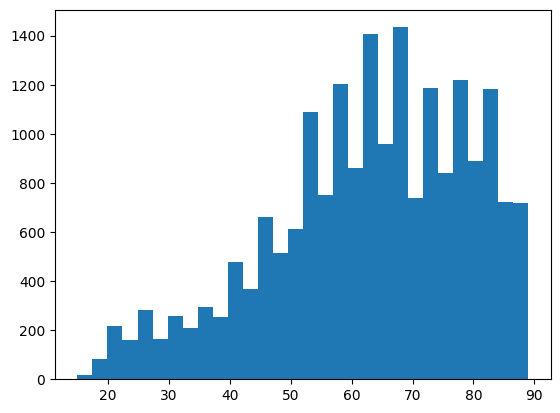

In [31]:
# Checking distribution of age
plt.hist(df_train['AGE'], bins=30);

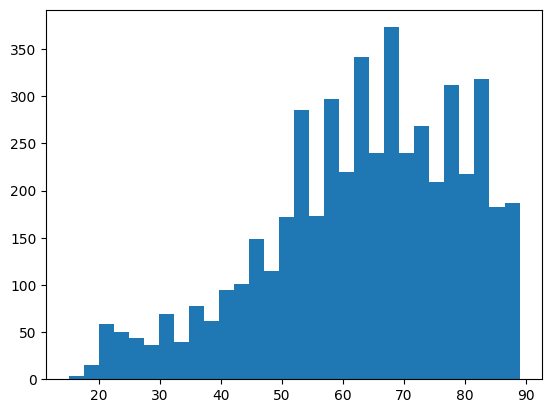

In [32]:
plt.hist(df_test['AGE'], bins=30);

The distribution of ages looks as expected. We created some NaN values which will be imputed below.

### Scaling variables

Scaling the data is very important when using algorithms like KNN which try to determine how close two observations are in euclidean space. Scaling the data ensures each feature contributes equally to the calculation of distance. Without scaling features with larger scales would have greater influence on the model.

Below I use robust scaling which uses the median and quantile range to scale the data. This approach is more sensitive to outliers so will control for the presence of outliers in some of the features.

The columns_to_scale variable below also determines what features will be included in the modelling. Notice that the religion and ethnicity variables are excluded as after experimenting, the inclusion of these variables reduced the out of sample performance of the models. 

In [33]:
# Scaling numerical and binary variables
columns_to_scale = ['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean','SpO2_Mean', 'Glucose_Mean', 'GENDER_F','GENDER_M', 
                    'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 
                    'INSURANCE_Private', 'INSURANCE_Self Pay', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER',
                    'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_WIDOWED', 'AGE', 'ICD9_1.0_encoded', 'ICD9_secondary']


scaler = RobustScaler()
scaler.fit(df_train[columns_to_scale])
df_train[columns_to_scale] = scaler.transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

### Imputing

The numerical variables in the data contained missing values. I use KNN imputing to fill these missing values. This works by assuming that similar observations have similar feature values, then taking the average of a set number of neighbors to impute the missing values in the data. Below I use 5 neighbors as after some experimentation this led to the best out of sample performance.

In [34]:
# Imputing missing numerical values with KNN imputer
columns_to_impute = ['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean','SpO2_Mean', 'Glucose_Mean', 'AGE', 'ICD9_1.0_encoded', 'ICD9_secondary'] 

imputer = KNNImputer(n_neighbors=5)
df_train[columns_to_impute] = imputer.fit_transform(df_train[columns_to_impute])
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute])

In [35]:
# Subset data with features to be used for modelling
X_train = df_train[columns_to_scale]
X_test = df_test[columns_to_scale]
y_train = df_train['LOS']

In [36]:
len(X_train.columns)

27

## Simple Neural Network - one hidden layer

To start with, I am going to train a neural network using keras, which has one hidden layer. The hidden layer with the ReLU activation function introduces non-linearity to the model, allowing it to learn complex patterns and relationships in the data that may not be captured by a simple linear model. This enables the neural network to model nonlinear mappings between the input and output.

The input layer will have 27 nodes, as this is the number of features I am feeding into the model.

The batch size and number of epochs was determined by manually iterating through different values until the model converged.

I also include early stopping in this simple model. This aims to try and prevent the network from overfitting by stopping the training process early. This allows the neural network to decide when it has done enough training to learn about the underlying function it wants to predict, but not too much training to overfit to the noise of the training set. Setting patience=3 means that training will continue until the validation loss stops decreasing for three consecutive epochs.

In [35]:
# Build the model.
SNN = Sequential([
 Dense(10, activation='relu', input_shape=(27,)),
 Dense(1, activation='exponential')
]) 

SNN.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=[metrics.RootMeanSquaredError()],
)

In [36]:
# Fit the model and store the training history
SNN_history = SNN.fit(
  X_train,
  y_train,
  epochs=50,
  batch_size=32,
  validation_split=0.3,
  callbacks=EarlyStopping(monitor='val_loss', patience=3)
)

Epoch 1/50
457/457 [==============================] - 1s 2ms/step - loss: 22.6134 - root_mean_squared_error: 4.7554 - val_loss: 19.0872 - val_root_mean_squared_error: 4.3689
Epoch 2/50
457/457 [==============================] - 1s 2ms/step - loss: 20.3599 - root_mean_squared_error: 4.5122 - val_loss: 18.9390 - val_root_mean_squared_error: 4.3519
Epoch 3/50
457/457 [==============================] - 1s 2ms/step - loss: 16.6105 - root_mean_squared_error: 4.0756 - val_loss: 17.0153 - val_root_mean_squared_error: 4.1250
Epoch 4/50
457/457 [==============================] - 1s 2ms/step - loss: 15.1783 - root_mean_squared_error: 3.8959 - val_loss: 16.4559 - val_root_mean_squared_error: 4.0566
Epoch 5/50
457/457 [==============================] - 1s 2ms/step - loss: 14.8249 - root_mean_squared_error: 3.8503 - val_loss: 16.1474 - val_root_mean_squared_error: 4.0184
Epoch 6/50
457/457 [==============================] - 1s 2ms/step - loss: 14.2348 - root_mean_squared_error: 3.7729 - val_loss: 16

In [37]:
SNN.evaluate(
  X_train,
  y_train
)

653/653 [==============================] - 1s 2ms/step - loss: 13.2468 - root_mean_squared_error: 3.6396


[13.24677848815918, 3.6396124362945557]

In [38]:
print(SNN_history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


After 22 epochs the validaiton loss stopped decreasing, so the network stopped training early. Below I check if the model has converged. A loss curve which has completely flattened signifies the model has converged.

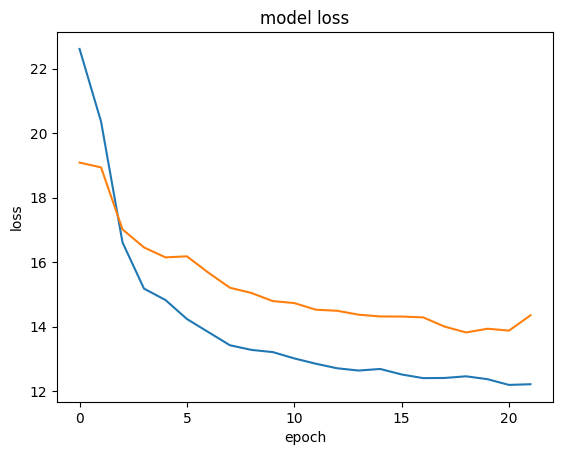

In [39]:
# Assessing convergence
plt.plot(SNN_history.history['loss'])
plt.plot(SNN_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Here we can see the loss function looks like it is starting to flatten, so we have some confidence that our model have converged. We will now try to make the model more complex by adding another hidden layer, which should improve the predictive performance of the model by making it more flexible in its fit to the data.

## Extending the model - adding another hidden layer, regularization and dropout

To make our model more flexible in how it fits to the data, I will add another hidden layer and regularization. Choosing the number of nodes to include in each layer can impact the performance of the model. Previous research suggests setting the first layer equal to the number of features plus one (which will be 28 in this case), while the other hidden layers should be somewhere between the input and output layer. It is common practice to set the hidden layer to two-thirds the size of the input layer, plus the size of the output layer. This gives us a hidden layer of size 20. 

When first trying a network of this size, the model coverged, however, after adding dropout, there were problems with convergence. Dropout regularization tends to yield better performance when applied to larger networks, so in the model below I increase the first layer to 40 nodes, and the other hidden layer to 29 nodes. Dropout works by randomly dropping out a proportion of the nodes in a layer during training. By randomly dropping out neurons during training, dropout effectively creates an ensemble of multiple different networks, each of which learns a different representation of the input data. This helps to prevent overfitting and should improve the out of sample prediciton of the network. The inclusion of dropout in this model also means I no longer include early stopping, as early stopping seemed to be occuring before the model had actually converged. I also had to increase the number of epochs to achieve convergence with dropout.

In this model I also add bias and kernel regularization. Kernel regularizers are used to apply penalties on the weights of the neural network layers, while bias regularizers are used to apply penalties on the biases of the neural network layers. For the weights, L1 regularization penalizes the absolute values of the weights, encouraging sparsity in the weight matrix, while L2 regularization penalizes the squared magnitudes of the weights, encouraging smaller weight values. For the bias, L2 regularization is used to penalize the squared magnitudes of the bias terms in the neural network layers. In the model below, I chose some standard regularization parameters. Once the network is converging I will gird search over a wider range of parameters to optimize the model.

I also set the initialization process of the bias and weights in the below model. The initialization process will impact the local minimum the loss function is optimizing towards, so a good initialization can lead us to a better performing model. Since I am using the ReLU activation function, I initialize the weights from a Normal distribution with mean 0 and standard deviation $\sqrt{\frac{2}{p_{L-1}}}$. The bias' are initialized to zero, as this is common practise.

In [89]:
MLP = Sequential([
        Dense(40, activation='relu', input_shape=(27,),
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              kernel_initializer=initializers.HeNormal(),
              bias_initializer=initializers.Zeros()),
        Dropout(0.1),
        Dense(29, activation='relu', 
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              kernel_initializer=initializers.HeNormal(),
              bias_initializer=initializers.Zeros()),
        Dropout(0.1),
        Dense(1, activation='exponential',
              kernel_initializer=initializers.HeNormal(),
              bias_initializer=initializers.Zeros())
    ])


MLP.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[metrics.RootMeanSquaredError()],
)

In [90]:
# Fit the model and store the training history
MLP_history = MLP.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.3,
    #callbacks=EarlyStopping(monitor='val_loss', patience=5)
)

Epoch 1/100


457/457 [==============================] - 2s 2ms/step - loss: 39.4017 - root_mean_squared_error: 6.2756 - val_loss: 28.4204 - val_root_mean_squared_error: 5.3294
Epoch 2/100
457/457 [==============================] - 1s 2ms/step - loss: 24.6781 - root_mean_squared_error: 4.9659 - val_loss: 25.7073 - val_root_mean_squared_error: 5.0684
Epoch 3/100
457/457 [==============================] - 1s 2ms/step - loss: 26.1632 - root_mean_squared_error: 5.1132 - val_loss: 24.3979 - val_root_mean_squared_error: 4.9375
Epoch 4/100
457/457 [==============================] - 1s 2ms/step - loss: 98.6257 - root_mean_squared_error: 9.9301 - val_loss: 31.9165 - val_root_mean_squared_error: 5.6478
Epoch 5/100
457/457 [==============================] - 2s 3ms/step - loss: 28.1089 - root_mean_squared_error: 5.3000 - val_loss: 25.8857 - val_root_mean_squared_error: 5.0859
Epoch 6/100
457/457 [==============================] - 1s 3ms/step - loss: 27.0390 - root_mean_squared_error: 5.1980 - val_loss: 25.3644 

In [91]:
MLP.evaluate(
  X_train,
  y_train
)

653/653 [==============================] - 1s 1ms/step - loss: 13.9044 - root_mean_squared_error: 3.7243


[13.904376983642578, 3.7242941856384277]

In [92]:
print(MLP_history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


We can now also assess the convergence of this model.

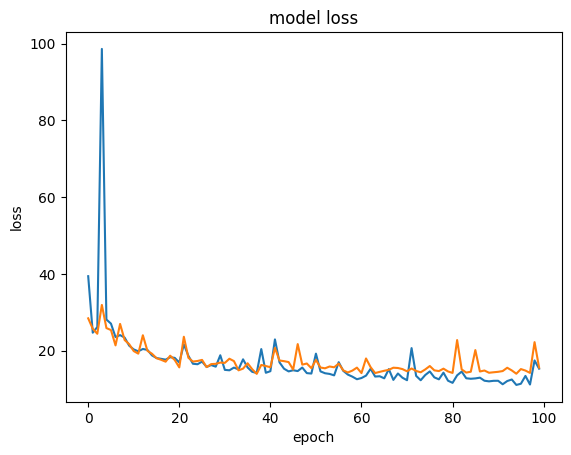

In [93]:
# Assessing convergence
plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Adding dropout means the loss curve fluctuates quite a lot (we can see early on there is a very big spike in the loss curve), however, we can still see that the model has converged with the fluctuation. We can now optimise our weights before using the model to make predictions.

## Grid Search - Optimising the model

Since we have now found a model that converges and works, we can grid search for the best regularization parameters. Note that due to limited computational power of my machine, I am only able to grid search over a small number of parameters for this project. It is likely the true optimal parameter lies outside of the range I am testing.

In [98]:
# Function to create model, required for KerasRegressor
def build_model(optimizer='adam', kernel_l1=1e-5, kernel_l2=1e-4, bias_l2=1e-4):
    # create model
    model = Sequential([
            Dense(40, activation='relu', input_shape=(27,),
                kernel_regularizer=regularizers.l1_l2(l1=kernel_l1, l2=kernel_l2),
                bias_regularizer=regularizers.l2(bias_l2),
                kernel_initializer=initializers.HeNormal(),
                bias_initializer=initializers.Zeros()),
            Dropout(0.1),
            Dense(29, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=kernel_l1, l2=kernel_l2),
                bias_regularizer=regularizers.l2(bias_l2),
                kernel_initializer=initializers.HeNormal(),
                bias_initializer=initializers.Zeros()),
            Dropout(0.1),
            Dense(1, activation='exponential',
                kernel_initializer=initializers.HeNormal(),
                bias_initializer=initializers.Zeros())
        ])

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[metrics.RootMeanSquaredError()])
    return model


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Define the model
gs_model = KerasRegressor(build_fn=build_model)

print(gs_model.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])


In [99]:
# Grid search over regularization parameters
optimizers = ['adam']
epochs = [10]
model__kernel_l1 = [1e-6, 1e-5, 1e-4]
model__kernel_l2 = [1e-5, 1e-4, 1e-3]
model__bias_l2 = [1e-5, 1e-4, 1e-3]

param_grid = dict(optimizer=optimizers, epochs=epochs, model__kernel_l1=model__kernel_l1, model__kernel_l2=model__kernel_l2, model__bias_l2=model__bias_l2)

grid = GridSearchCV(estimator=gs_model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
523/523 [==============================] - 1s 1ms/step - loss: 30842.3203 - root_mean_squared_error: 175.6198
Epoch 2/10
523/523 [==============================] - 1s 1ms/step - loss: 64.3431 - root_mean_squared_error: 8.0213
Epoch 3/10
523/523 [==============================] - 1s 1ms/step - loss: 175.3929 - root_mean_squared_error: 13.2435
Epoch 4/10
523/523 [==============================] - 1s 1ms/step - loss: 41.4075 - root_mean_squared_error: 6.4347
Epoch 5/10
523/523 [==============================] - 1s 2ms/step - loss: 43.4124 - root_mean_squared_error: 6.5887
Epoch 6/10
523/523 [==============================] - 1s 2ms/step - loss: 305.6882 - root_mean_squared_error: 17.4839
Epoch 7/10
523/523 [==============================] - 1s 2ms/step - loss: 19.6843 - root_mean_squared_error: 4.4365
Epoch 8/10
523/523 [==============================] - 1s 2ms/step - loss: 51.0993 - root_mean_squared_error: 7.1482
Epoch 9/10
523/523 [==============================] - 1s 2ms/st

In [43]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.508041 using {'epochs': 10, 'model__bias_l2': 0.0001, 'model__kernel_l1': 1e-06, 'model__kernel_l2': 0.0001, 'optimizer': 'adam'}
nan (nan) with: {'epochs': 10, 'model__bias_l2': 1e-05, 'model__kernel_l1': 1e-06, 'model__kernel_l2': 1e-05, 'optimizer': 'adam'}
nan (nan) with: {'epochs': 10, 'model__bias_l2': 1e-05, 'model__kernel_l1': 1e-06, 'model__kernel_l2': 0.0001, 'optimizer': 'adam'}
nan (nan) with: {'epochs': 10, 'model__bias_l2': 1e-05, 'model__kernel_l1': 1e-06, 'model__kernel_l2': 0.001, 'optimizer': 'adam'}
-0.514029 (0.027357) with: {'epochs': 10, 'model__bias_l2': 1e-05, 'model__kernel_l1': 1e-05, 'model__kernel_l2': 1e-05, 'optimizer': 'adam'}
-0.514022 (0.027395) with: {'epochs': 10, 'model__bias_l2': 1e-05, 'model__kernel_l1': 1e-05, 'model__kernel_l2': 0.0001, 'optimizer': 'adam'}
nan (nan) with: {'epochs': 10, 'model__bias_l2': 1e-05, 'model__kernel_l1': 1e-05, 'model__kernel_l2': 0.001, 'optimizer': 'adam'}
nan (nan) with: {'epochs': 10, 'model__bias_l2': 1e

Now we have optimized the regularization parameters for the more complex model. I will use this model to predict the test data for the kaggle submission.

In [ ]:
# Get predictions for the test data
y_pred_test = grid.predict(X_test)

In [ ]:
# Save predictions
pred = pd.DataFrame({'icustay_id': df_test['icustay_id'],
                          'LOS': y_pred_test.flatten()})
    
pred.to_csv("NN_keras_preds.csv", index = False)

## Ensembles - Stacking

Stacking is an ensemble learning technique that combines multiple base models into a meta-learner (super-learner) to improve predictive performance. It aims to leverage the strengths of individual models while mitigating their weaknesses, ultimately creating a more robust and accurate predictive model. This basically consists of training an extra model on the output of baseline models in order to infer the best way to combine them to yield a prediction.

I will evaluate the performance of two meta-learners: ExtraTreesRegressor and GradientBoostingRegressor. These meta learners will be made up of the following base learners: KNN, Linear Regression, and Random Forest Regressor.

As with the previous grid search, I only search over a small number of parameters for this project due to limited computation capacity. It is likely the true optimal parameter lies outside of the range I am testing. I was also initially including SVR as another base learner, however it was making the grid search take too long to run, so I excluded it.

In [76]:
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


models = [
    ('knn', KNeighborsRegressor()),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor())
 ]


meta_learners = [
    ExtraTreesRegressor(n_estimators=100, max_features=0.5, bootstrap=True),
    GradientBoostingRegressor(learning_rate=0.1, n_estimators=100)
]


meta_learners_ = ['ExtraTrees', 'GradientBoosting']

grid_values = {'knn__n_neighbors': [1, 20, 100],
               'knn__weights': ['uniform', 'distance'],
               'lr__fit_intercept': [True, False],
               'rf__n_estimators': [50, 100],
               'rf__max_depth':[5, 10]}


final_models = {}


for i, meta_learner in enumerate(meta_learners):
    sl = StackingRegressor(estimators=models, final_estimator=meta_learner, cv=3)
    
    grid_sl = GridSearchCV(sl, param_grid = grid_values, scoring = 'neg_root_mean_squared_error', cv=3, verbose=1)

    # Train the ensemble
    grid_sl.fit(X_train, y_train)
    
    print(f'Super Learner with {meta_learners_[i]} best parameters: {grid_sl.best_params_}')
    print(f'Super Learner with {meta_learners_[i]} best score: {-grid_sl.best_score_}')
        
    y_pred_test_sl = grid_sl.predict(X_test)
    
    # Save predictions for meta learner
    pred_sl = pd.DataFrame({'icustay_id': df_test['icustay_id'],
                              'LOS': y_pred_test_sl.flatten()})

    pred_sl.to_csv(f"NN_keras_sl_{meta_learners_[i]}.csv", index = False)
    
    # Save final model in dict
    final_models[meta_learners_[i]] = grid_sl


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Super Learner with ExtraTrees best parameters: {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'lr__fit_intercept': True, 'rf__max_depth': 10, 'rf__n_estimators': 100}
Super Learner with ExtraTrees best score: 3.5705522854366656
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Super Learner with GradientBoosting best parameters: {'knn__n_neighbors': 100, 'knn__weights': 'distance', 'lr__fit_intercept': True, 'rf__max_depth': 10, 'rf__n_estimators': 100}
Super Learner with GradientBoosting best score: 3.5076679247851543


Based on the in sample loss, the GradientBoostingRegressor performs slightly better than the ExtraTreesRegressor, so this will be my preffered ensemble model.

## Model Interpretability

Now, I seek to enhance the GradientBoostingRegressors interpretability by leveraging the SHAP (SHapley Additive exPlanations) library. Using SHAP, we can understand the contribution of each feature to the prediction of a machine learning model. Shaply values attribute to each feature the change in the expected model prediction when conditioning on that feature.

In [39]:
# Extract the best estimator from GridSearchCV
best_GradientBoosting_estimator = final_models['GradientBoosting'].best_estimator_
best_GradientBoosting_estimator

StackingRegressor(cv=3,
                  estimators=[('knn',
                               KNeighborsRegressor(n_neighbors=100,
                                                   weights='distance')),
                              ('lr', LinearRegression()),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=50))],
                  final_estimator=GradientBoostingRegressor())

Below I set up the explainer. I use a summary of the background data to reduce the computational complexity by providing a representative subset of the entire dataset. This allows for faster computation of SHAP values, especially for large datasets.

In [55]:
# Initialize SHAP explainer with the trained model

# Summarize the background data using shap.kmeans to deacrease the number of clusters
background_summary = shap.kmeans(X_train, 100) 
explainer = shap.KernelExplainer(best_GradientBoosting_estimator.predict, background_summary)

Here I compute the SHAP values using only 1,500 observations from the test data. I tried to use the while test dataset but the code took too long to run.

In [56]:
# Compute SHAP values
shap_values = explainer.shap_values(X_test[:1500])

100%|██████████| 1500/1500 [3:27:09<00:00,  8.29s/it]  


First we look at the global explanation of the test set. This plot provides a summary of the importance of each feature in the dataset as determined by their SHAP values.

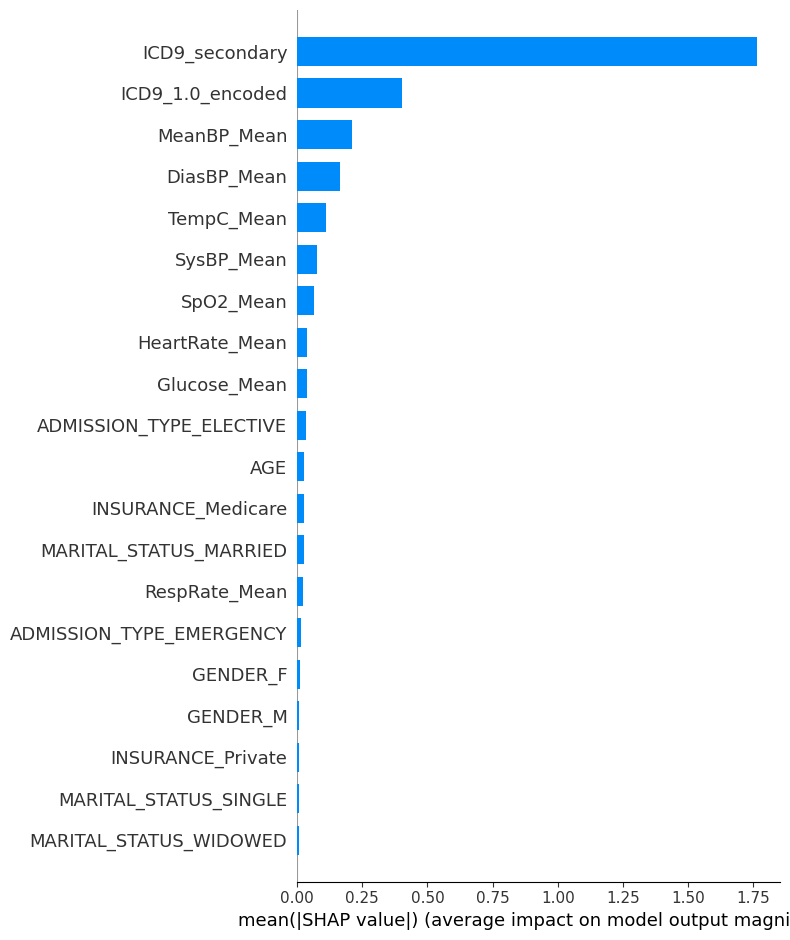

In [57]:
# Visualize SHAP explanations on the test set
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

As can be seen in the above plot, the ICD9_secondary column has the largest inpact on the models output. This is unsurprising as this feature contains important information about the disease diagnosis of the patient, which is likely to be highly deterministic of the amount of time a patient stays in hospital. After the ICD9 variables, we find the numerical measures of a patients health (blood pressure, temperature etc) are also important within the models decision making process.

To investigate the ICD9_secondary feature more, I show its dependence plot. This helps us the understand how changes in the ICD9_secondary feature impacts the models predictions.

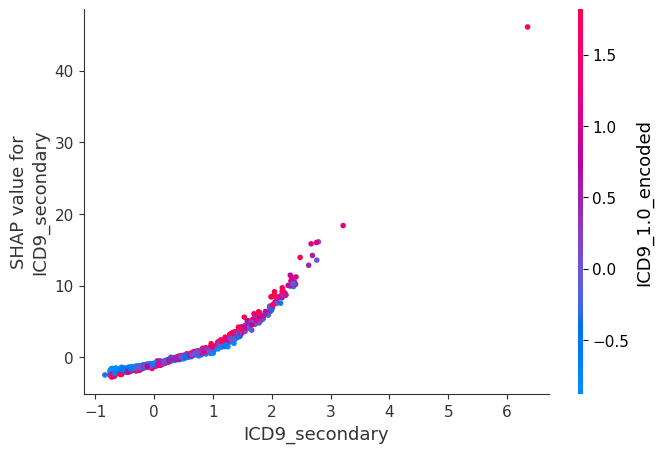

In [74]:
shap.dependence_plot("ICD9_secondary", shap_values, X_test[:1500])

The y-axis represents the SHAP values associated with ICD9_secondary.  Positive SHAP values indicate that higher values of the feature tend to increase the model's output, while negative SHAP values indicate the opposite effect. (Note that the x-axis here is not the true values of ICD9_secondary as it has been standardised). As can be seen in the plot, higher values of the ICD9_secondary variable (indicating diagnosis with longer length of stay, as this variable was target encoded), have a positive impact on the length of stay prediction of the model.

Below we also plot the dependence plot for the mean blood pressure.

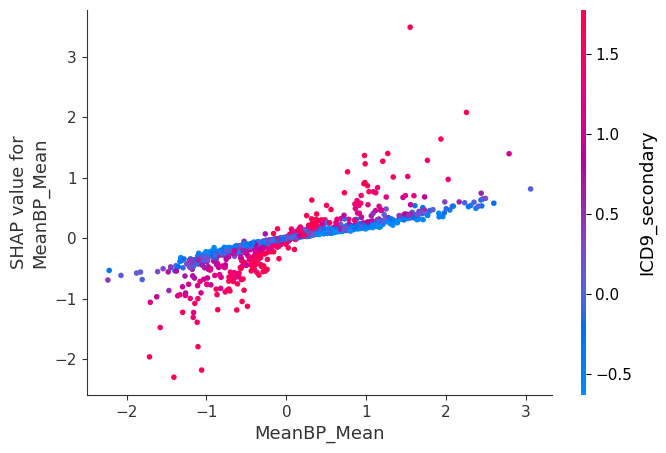

In [75]:
shap.dependence_plot("MeanBP_Mean", shap_values, X_test[:1500])

Analysing the impact of mean blood pressure on the model, we can see that having a higher mean blood pressure leads to more positive shap values, and therfore a prediction for a longer length of stay in hospital.

Finally, we can get a summary of effect of each feature on the final result with the summary plot. This shows each features' shap values so we can see how they are impacting the model.

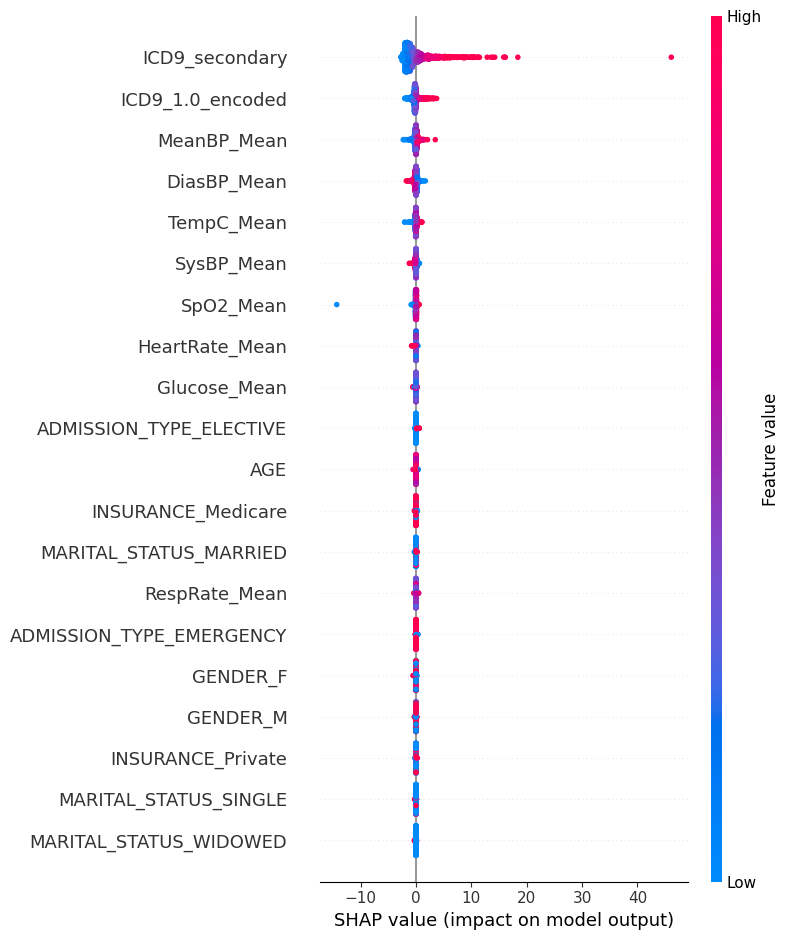

In [66]:
shap.initjs()
shap.summary_plot(shap_values, X_test[:1500])

As already explored above, the ICD9_secondary feature has the biggest impact on the model, as this gets higher, the predicted length of stay gets higher. I should note that this finding is not surprising considering this variable was target encoded.

The above analysis has increased the interpretability of our results. We are now more informed about which features of our model are the most important for the prediction, which is often extremely important and highly valued in real world applications.